In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.datasets import load_iris
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Step 1: Load the Iris dataset

file_path = "/content/drive/MyDrive/Data Science Projects/Beginner/Notebook/Datasets/winequality.csv"
data = pd.read_csv(file_path)
output_path = "/content/drive/MyDrive/Data Science Projects/App/app/static"
os.makedirs(output_path, exist_ok=True)

In [4]:
# Step 2: Explore the data

print("Data Head:\n", data.head())
print("\nData Info:\n", data.info())
print("\nData Description:\n", data.describe())

Data Head:
     type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0  white            7.0              0.27         0.36            20.7   
1  white            6.3              0.30         0.34             1.6   
2  white            8.1              0.28         0.40             6.9   
3  white            7.2              0.23         0.32             8.5   
4  white            7.2              0.23         0.32             8.5   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.045                 45.0                 170.0   1.0010  3.00   
1      0.049                 14.0                 132.0   0.9940  3.30   
2      0.050                 30.0                  97.0   0.9951  3.26   
3      0.058                 47.0                 186.0   0.9956  3.19   
4      0.058                 47.0                 186.0   0.9956  3.19   

   sulphates  alcohol  quality  
0       0.45      8.8        6  
1       0.49      9.5        6  

In [5]:
# Step 3: Column details

print("\nColumn Details:")
for col in data.columns:
    print(f"Column: {col}, Type: {data[col].dtype}, Unique values: {data[col].nunique()}")


Column Details:
Column: type, Type: object, Unique values: 2
Column: fixed acidity, Type: float64, Unique values: 106
Column: volatile acidity, Type: float64, Unique values: 187
Column: citric acid, Type: float64, Unique values: 89
Column: residual sugar, Type: float64, Unique values: 316
Column: chlorides, Type: float64, Unique values: 214
Column: free sulfur dioxide, Type: float64, Unique values: 135
Column: total sulfur dioxide, Type: float64, Unique values: 276
Column: density, Type: float64, Unique values: 998
Column: pH, Type: float64, Unique values: 108
Column: sulphates, Type: float64, Unique values: 111
Column: alcohol, Type: float64, Unique values: 111
Column: quality, Type: int64, Unique values: 7


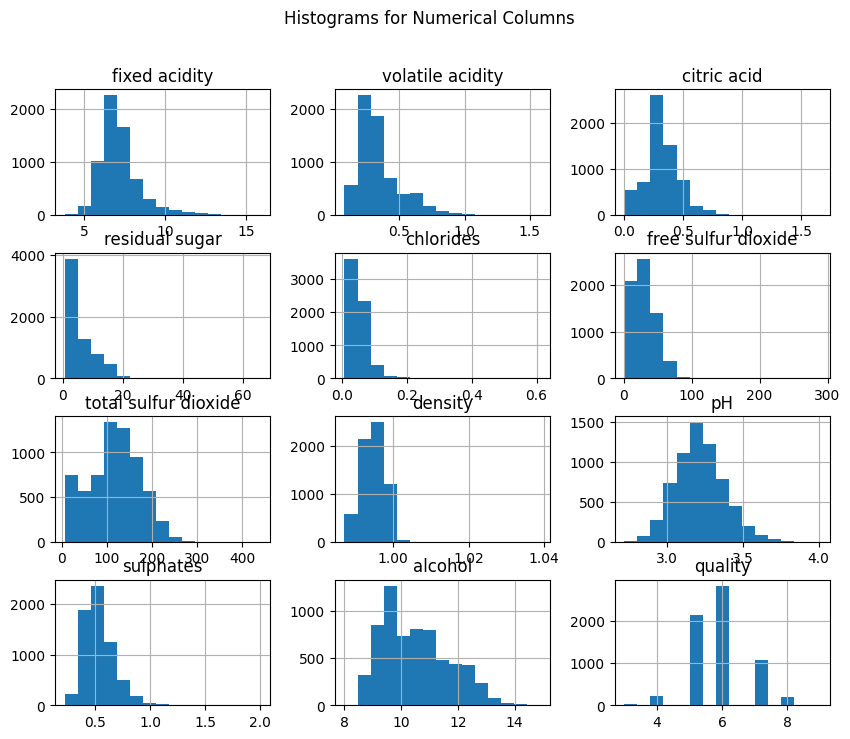

In [6]:
# Step 4: Visualize histograms for each numerical column

data.hist(bins=15, figsize=(10, 8))
plt.suptitle("Histograms for Numerical Columns")
# plt.show()
plt.savefig(os.path.join(output_path, "wine_histograms.png"))

In [7]:
# Step 5: Handle missing values

# Display the number of missing values per column
print("Number of missing values in each column before filling:")
print(data.isnull().sum())

# Save the mean values for numerical columns with missing values
mean_values_with_na = data.mean(numeric_only=True)

# Save the mode values for categorical columns with missing values
mode_values_with_na = data.mode().iloc[0]

Number of missing values in each column before filling:
type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64


In [8]:
# Fill missing values with the mean of numerical columns and mode of categorical columns
for column in data.columns:
    if data[column].dtype == 'object':  # Categorical columns
        if data[column].isnull().any():
            data[column].fillna(mode_values_with_na[column], inplace=True)
    else:  # Numerical columns
        if data[column].isnull().any():
            data[column].fillna(mean_values_with_na[column], inplace=True)

In [9]:
# Display the mean/mode values used to fill each column with missing values
print("\nValues used to fill columns with missing values:")
for column in data.columns:
    if data[column].dtype == 'object':  # Categorical columns
        if column in mode_values_with_na:
            print(f"{column}: {mode_values_with_na[column]}")
    else:  # Numerical columns
        if column in mean_values_with_na:
            print(f"{column}: {mean_values_with_na[column]}")


Values used to fill columns with missing values:
type: white
fixed acidity: 7.2165793124710955
volatile acidity: 0.33969101556480197
citric acid: 0.3187218971358176
residual sugar: 5.444326404926867
chlorides: 0.05604157043879908
free sulfur dioxide: 30.525319378174544
total sulfur dioxide: 115.7445744189626
density: 0.9946966338309989
pH: 3.218395499383477
sulphates: 0.531215154782073
alcohol: 10.491800831149455
quality: 5.818377712790519


In [10]:
# Step 6: Identify and remove outliers using IQR (Interquartile Range)

# Identifying outliers for each numeric column
outlier_columns = []
outliers_dict = {}

# Iterate over each numeric column in the dataset
for feature in data.select_dtypes(include=[np.number]).columns:
    # Calculate Q1 (25th percentile), Q3 (75th percentile), and IQR (Interquartile Range)
    Q1 = data[feature].quantile(0.25)  # 25th percentile
    Q3 = data[feature].quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1  # Interquartile Range (difference between Q3 and Q1)

    # Identify outliers using the IQR rule: values lower than Q1 - 1.5 * IQR or higher than Q3 + 1.5 * IQR
    outlier_mask = (data[feature] < (Q1 - 1.5 * IQR)) | (data[feature] > (Q3 + 1.5 * IQR))

    # If there are any outliers for this feature, store them in the outliers_dict
    if outlier_mask.any():  # If there is at least one outlier
        outliers_dict[feature] = data[outlier_mask]  # Store outliers in the dictionary
        outlier_columns.append(feature)  # Add the feature name to the outlier_columns list


Outliers Detected for fixed acidity:
       type  fixed acidity  volatile acidity  citric acid  residual sugar  \
98    white            9.8              0.36         0.46           10.50   
169   white            9.8              0.42         0.48            9.85   
207   white           10.2              0.44         0.88            6.20   
358   white           10.0              0.20         0.39            1.40   
873   white           10.3              0.17         0.47            1.40   
...     ...            ...               ...          ...             ...   
6368    red           10.0              0.69         0.11            1.40   
6372    red            9.9              0.50         0.50           13.80   
6374    red            9.9              0.50         0.50           13.80   
6441    red           11.1              0.44         0.42            2.20   
6446    red           11.2              0.40         0.50            2.00   

      chlorides  free sulfur dioxide 

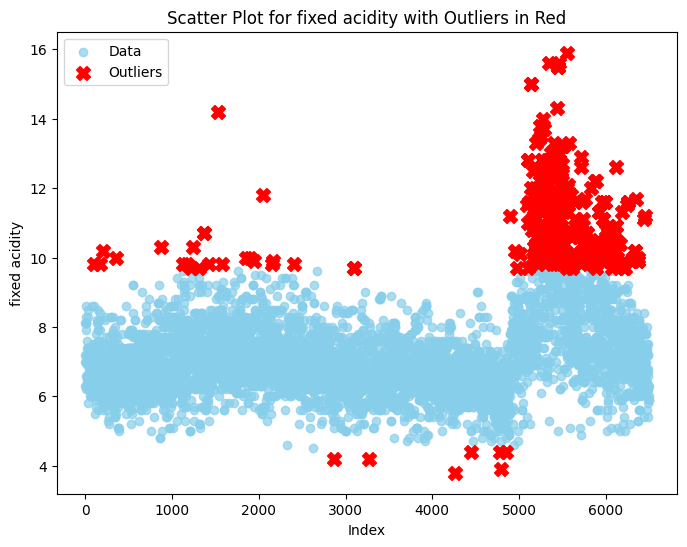

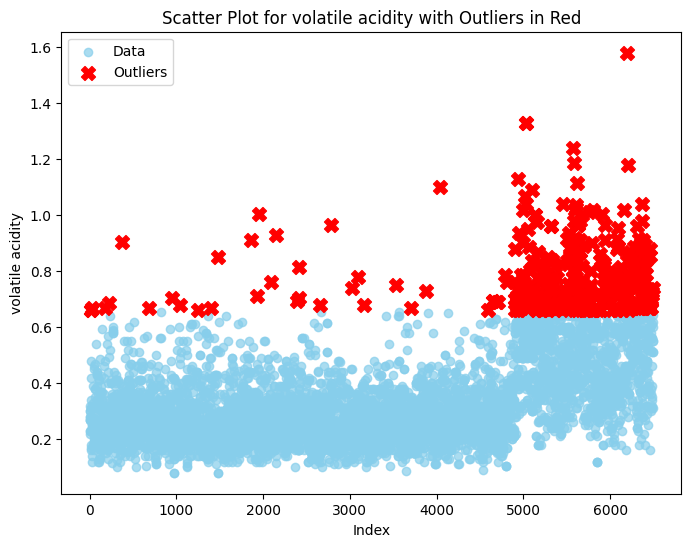

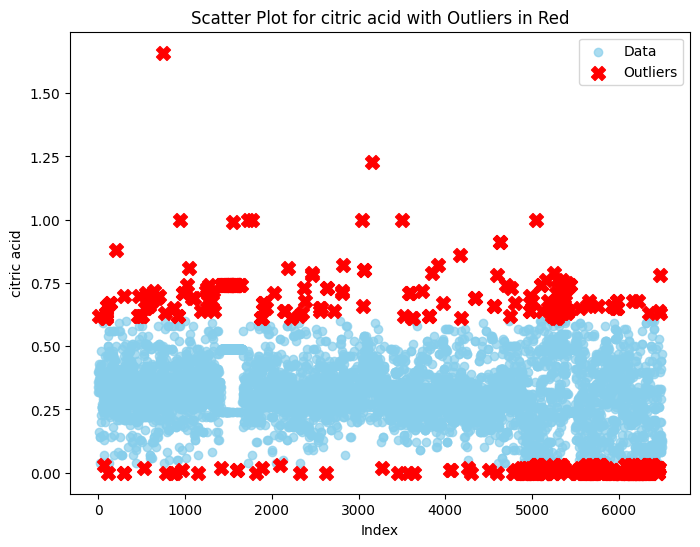

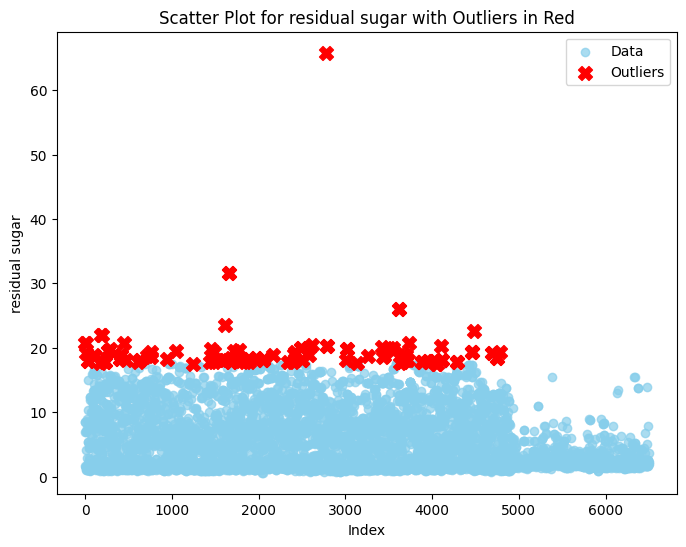

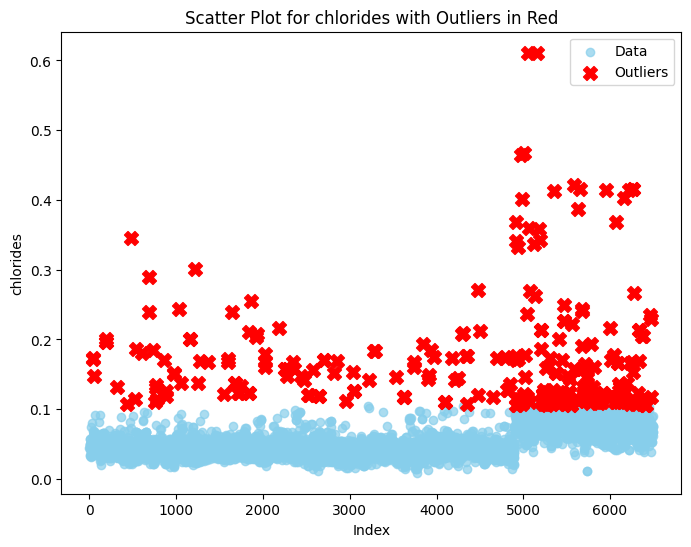

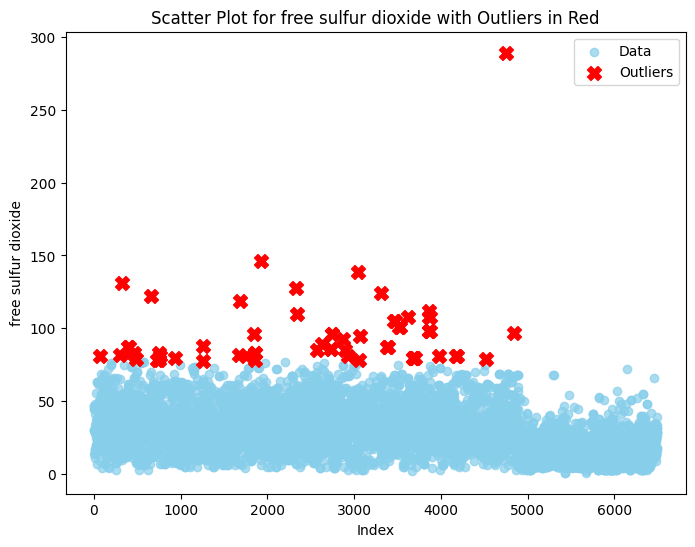

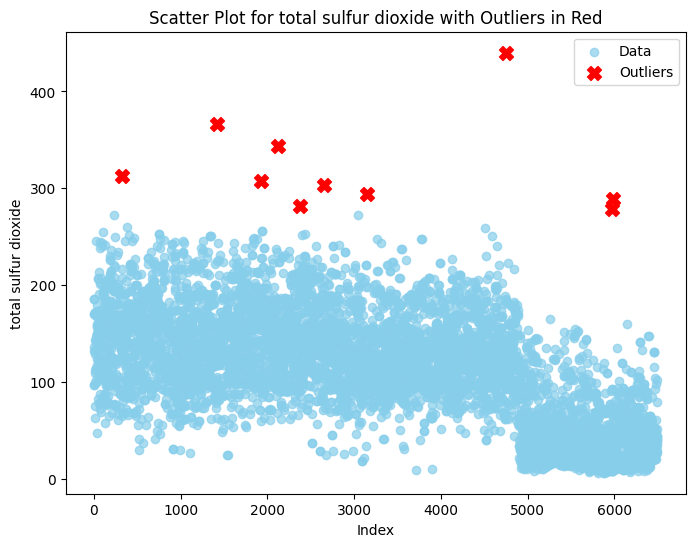

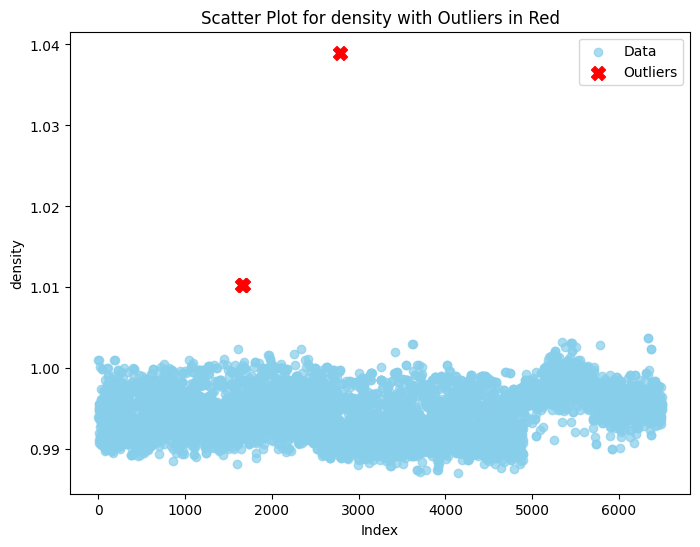

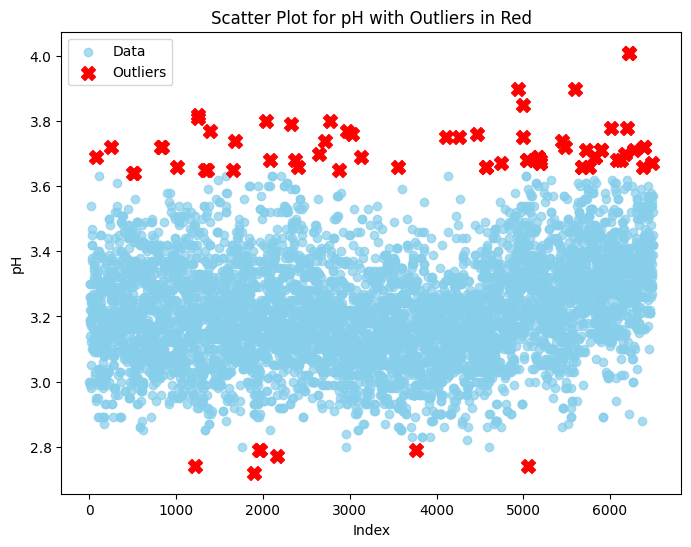

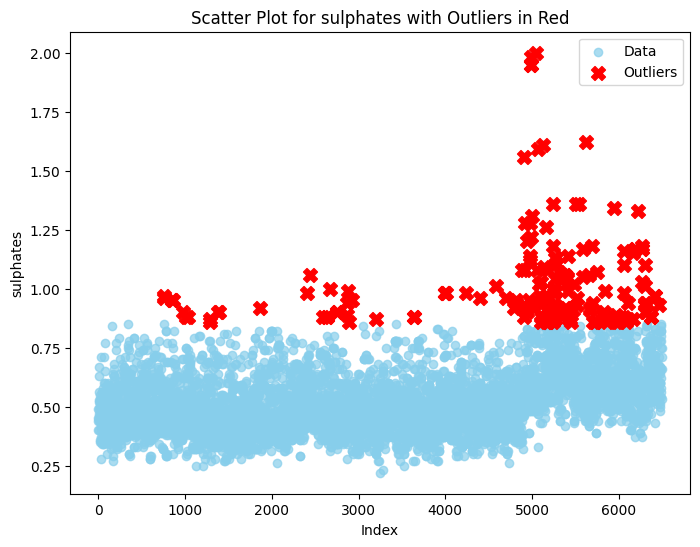

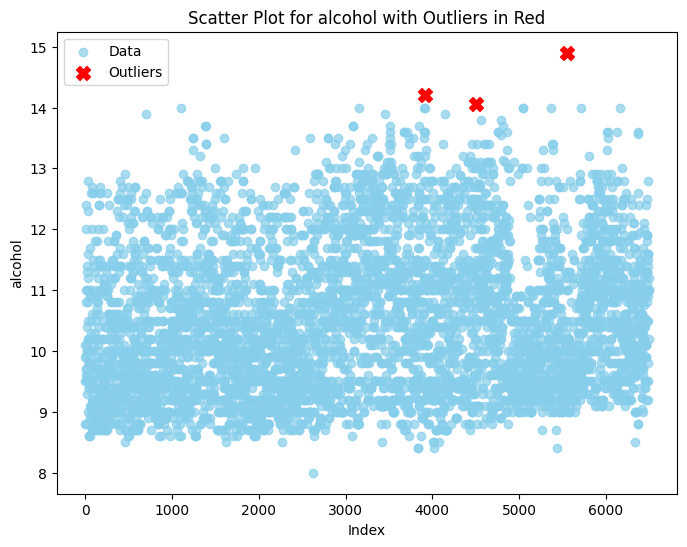

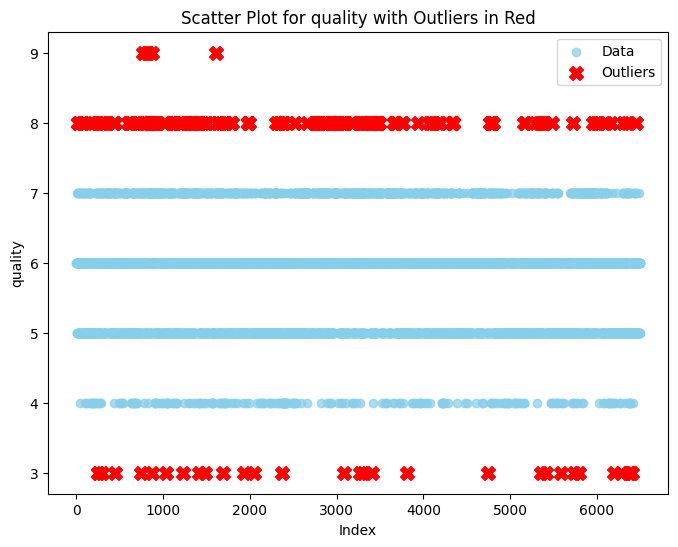

In [11]:
# Generate scatter plots only for the columns that contain outliers
for feature in outlier_columns:
    plt.figure(figsize=(8, 6))  # Create a figure for the scatter plot

    # Plot all data points (excluding outliers) for the feature
    non_outliers = data[~outlier_mask]  # Data without outliers
    plt.scatter(non_outliers.index, non_outliers[feature], color='skyblue', label="Data", alpha=0.7)

    # Plot the outliers in red
    outliers = outliers_dict[feature]  # Get the outliers for the current feature
    plt.scatter(outliers.index, outliers[feature], color='red', label="Outliers", s=100, marker='X')

    # Set title and labels for the plot
    plt.title(f"Scatter Plot for {feature} with Outliers in Red")
    plt.xlabel('Index')
    plt.ylabel(feature)
    plt.legend()
    # plt.show()
    plot_filename = f"wine_scatter_{feature}.png"  # Use feature name in the file
    plt.savefig(os.path.join(output_path, plot_filename))

    # Print the outliers detected for the current feature
    print(f"\nOutliers Detected for {feature}:")
    print(outliers)


In [12]:
# Visualize the original data with a pairplot (including outliers)
sns.pairplot(data, hue='fixed acidity', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with fixed acidity Class Labels (Including Outliers)", y=1.02)
# plt.show()
plt.savefig(os.path.join(output_path, "wine_outliers_fixed.png"))

# Visualize the original data with a pairplot (including outliers)
sns.pairplot(data, hue='volatile acidity', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with volatile acidity Class Labels (Including Outliers)", y=1.02)
# plt.show()
plt.savefig(os.path.join(output_path, "wine_outliers_volatile.png"))

# Visualize the original data with a pairplot (including outliers)
sns.pairplot(data, hue='citric acid', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with citric acid Class Labels (Including Outliers)", y=1.02)
# plt.show()
plt.savefig(os.path.join(output_path, "wine_outliers_citric.png"))

# Visualize the original data with a pairplot (including outliers)
sns.pairplot(data, hue='residual sugar', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with residual sugar Class Labels (Including Outliers)", y=1.02)
# plt.show()
plt.savefig(os.path.join(output_path, "wine_outliers_residual.png"))

# Visualize the original data with a pairplot (including outliers)
sns.pairplot(data, hue='chlorides', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with chlorides Class Labels (Including Outliers)", y=1.02)
# plt.show()
plt.savefig(os.path.join(output_path, "wine_outliers_chlorides.png"))

# Visualize the original data with a pairplot (including outliers)
sns.pairplot(data, hue='free sulfur dioxide', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with free sulfur dioxide Class Labels (Including Outliers)", y=1.02)
# plt.show()
plt.savefig(os.path.join(output_path, "wine_outliers_free.png"))

# Visualize the original data with a pairplot (including outliers)
sns.pairplot(data, hue='total sulfur dioxide', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with total sulfur dioxide Class Labels (Including Outliers)", y=1.02)
# plt.show()
plt.savefig(os.path.join(output_path, "wine_outliers_total.png"))

# Visualize the original data with a pairplot (including outliers)
sns.pairplot(data, hue='density', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with density Class Labels (Including Outliers)", y=1.02)
# plt.show()
plt.savefig(os.path.join(output_path, "wine_outliers_density.png"))

# Visualize the original data with a pairplot (including outliers)
sns.pairplot(data, hue='pH', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with pH Class Labels (Including Outliers)", y=1.02)
# plt.show()
plt.savefig(os.path.join(output_path, "wine_outliers_ph.png"))

# Visualize the original data with a pairplot (including outliers)
sns.pairplot(data, hue='sulphates', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with sulphates Class Labels (Including Outliers)", y=1.02)
# plt.show()
plt.savefig(os.path.join(output_path, "wine_outliers_sulphates.png"))

# Visualize the original data with a pairplot (including outliers)
sns.pairplot(data, hue='alcohol', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with alcohol Class Labels (Including Outliers)", y=1.02)
# plt.show()
plt.savefig(os.path.join(output_path, "wine_outliers_alcohol.png"))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-b85afe80a892>", line 2, in <cell line: 2>
    sns.pairplot(data, hue='fixed acidity', plot_kws={'alpha': 0.5})
  File "/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py", line 2177, in pairplot
    grid.add_legend()
  File "/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py", line 203, in add_legend
    _draw_figure(self._figure)
  File "/usr/local/lib/python3.10/dist-packages/seaborn/utils.py", line 61, in _draw_figure
    fig.canvas.draw()
  File "/usr/local/lib/python3.10/dist-packages/matplotlib/backends/backend_agg.py", line 388, in draw
    self.figure.draw(self.renderer)
  File "/usr/local/lib/python3.10/dist-packages/matplotlib/artist.py", line 95, in draw_wrapper
    result = draw(artist, renderer, *args, **kwargs)
  File "/usr/local/lib/pyt

TypeError: object of type 'NoneType' has no len()

Error in callback <function flush_figures at 0x78b1365451b0> (for post_execute):


KeyboardInterrupt: 

In [13]:
# Remove the outliers from the dataset

cleaned_data = data.copy()

# Loop through outlier columns to remove outliers
for feature in outlier_columns:
    outliers = outliers_dict[feature]  # Get outliers for the current feature
    cleaned_data = cleaned_data[~cleaned_data.index.isin(outliers.index)]  # Remove rows with outliers

In [ ]:
# Visualize the cleaned data with a pairplot (after removing outliers)
sns.pairplot(cleaned_data, hue='fixed acidity', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with fixed acidity Class Labels (After Removing Outliers)", y=1.02)
# plt.show()
plt.savefig(os.path.join(output_path, "wine_removed_outliers_fixed.png"))

# Visualize the cleaned data with a pairplot (after removing outliers)
sns.pairplot(cleaned_data, hue='volatile acidity', plot_kws={'alpha': 0.5})
# plt.show()
plt.savefig(os.path.join(output_path, "wine_removed_outliers_volatile.png"))

# Visualize the original data with a pairplot (including outliers)
sns.pairplot(cleaned_data, hue='citric acid', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with citric acid Class Labels (After Removing Outliers)", y=1.02)
# plt.show()
plt.savefig(os.path.join(output_path, "wine_removed_outliers_citric.png"))

# Visualize the original data with a pairplot (including outliers)
sns.pairplot(cleaned_data, hue='residual sugar', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with residual sugar Class Labels (After Removing Outliers)", y=1.02)
# plt.show()
plt.savefig(os.path.join(output_path, "wine_removed_outliers_citric.png"))

# Visualize the original data with a pairplot (including outliers)
sns.pairplot(cleaned_data, hue='chlorides', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with chlorides Class Labels (After Removing Outliers)", y=1.02)
# plt.show()
plt.savefig(os.path.join(output_path, "wine_removed_outliers_chlorides.png"))

# Visualize the original data with a pairplot (including outliers)
sns.pairplot(cleaned_data, hue='free sulfur dioxide', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with free sulfur dioxide Class Labels (After Removing Outliers)", y=1.02)
# plt.show()
plt.savefig(os.path.join(output_path, "wine_removed_outliers_free.png"))

# Visualize the original data with a pairplot (including outliers)
sns.pairplot(cleaned_data, hue='total sulfur dioxide', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with total sulfur dioxide Class Labels (After Removing Outliers)", y=1.02)
# plt.show()
plt.savefig(os.path.join(output_path, "wine_removed_outliers_total.png"))

# Visualize the original data with a pairplot (including outliers)
sns.pairplot(cleaned_data, hue='density', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with density Class Labels (After Removing Outliers)", y=1.02)
# plt.show()
plt.savefig(os.path.join(output_path, "wine_removed_outliers_density.png"))

# Visualize the original data with a pairplot (including outliers)
sns.pairplot(cleaned_data, hue='pH', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with pH Class Labels (After Removing Outliers)", y=1.02)
# plt.show()
plt.savefig(os.path.join(output_path, "wine_removed_outliers_ph.png"))

# Visualize the original data with a pairplot (including outliers)
sns.pairplot(cleaned_data, hue='sulphates', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with sulphates Class Labels (After Removing Outliers)", y=1.02)
# plt.show()
plt.savefig(os.path.join(output_path, "wine_removed_outliers_sulphates.png"))

# Visualize the original data with a pairplot (including outliers)
sns.pairplot(cleaned_data, hue='alcohol', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with alcohol Class Labels (After Removing Outliers)", y=1.02)
# plt.show()
plt.savefig(os.path.join(output_path, "wine_removed_outliers_alcohol.png"))

In [14]:
# Step 8: Preprocess the data

# Encode the target variable
label_encoder = LabelEncoder()
data['quality'] = label_encoder.fit_transform(data['quality'])

In [15]:
# Step 9: Handle non-numeric columns in X

# Convert categorical features to numeric using one-hot encoding or label encoding
# Here we use LabelEncoder for each categorical column (excluding the target 'Loan_Status')
for column in data.select_dtypes(include=['object']).columns:
    if column != 'quality':  # Avoid encoding the target variable
        label_encoder = LabelEncoder()
        data[column] = label_encoder.fit_transform(data[column])

In [16]:
# Step 10: Define features (X) and target (y)

X = data.drop(columns=['quality'])  # Features
y = data['quality']  # Target variable

# Step 11: Split data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Step 12: Feature scaling

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [18]:
# Step 12: Model selection and training

# Logistic Regression
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

# Decision Tree
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

# Random Forest
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [19]:
# Step 13: Model evaluation

models = {
    "Logistic Regression": logistic_model,
    "Decision Tree": tree_model,
    "Random Forest": rf_model
}

In [20]:
# Step 14: Display metrics

# Initialize dictionaries for storing metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
conf_matrices = {}
class_reports = {}

# Calculate metrics for each model
for model_name, model in models.items():
    pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average="weighted")
    recall = recall_score(y_test, pred, average="weighted")
    f1 = f1_score(y_test, pred, average="weighted")

    # Append metric scores
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Store confusion matrices and classification reports if needed
    conf_matrices[model_name] = confusion_matrix(y_test, pred)
    class_reports[model_name] = classification_report(y_test, pred)

In [21]:
# Creating the DataFrame with the metrics
metrics_df = pd.DataFrame({
    "Model": list(models.keys()),
    "Accuracy": accuracy_scores,
    "Precision": precision_scores,
    "Recall": recall_scores,
    "F1 Score": f1_scores
})

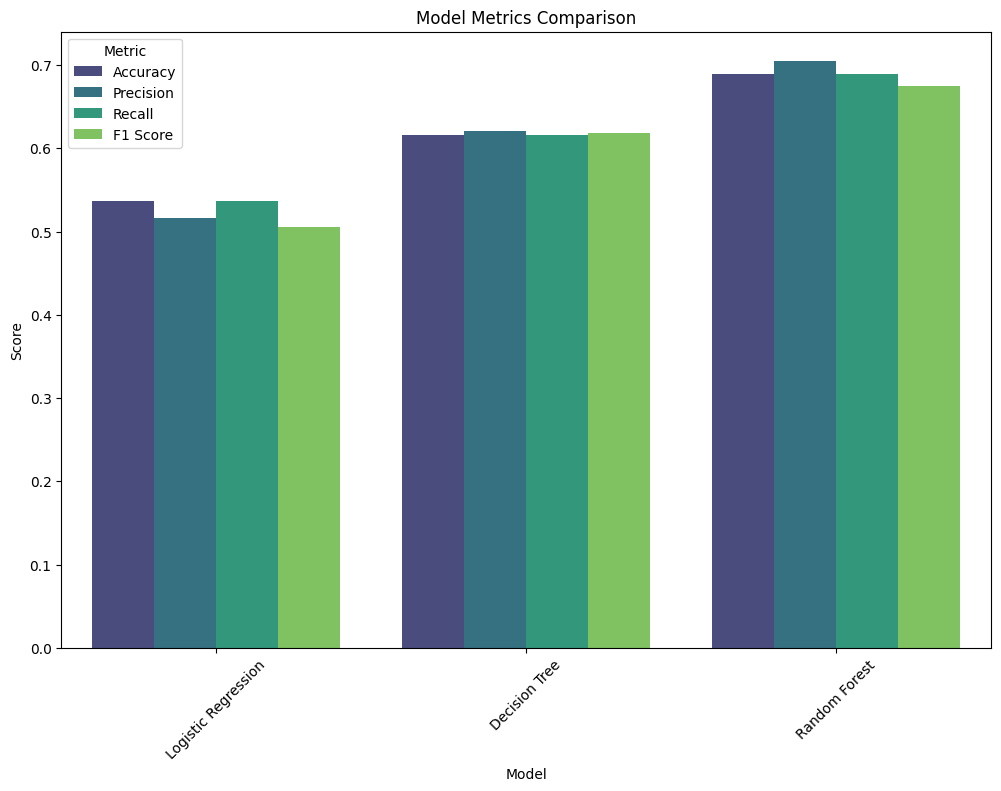

In [22]:
# Melt the DataFrame for easier plotting with Seaborn
metrics_melted = metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Score")

# Plotting the metrics
plt.figure(figsize=(12, 8))
sns.barplot(data=metrics_melted, x="Model", y="Score", hue="Metric", palette="viridis")
plt.title("Model Metrics Comparison")
plt.xlabel("Model")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(title="Metric")
# plt.show()
# Save the plot
plt.savefig(os.path.join(output_path, "wine_metrics.png"))

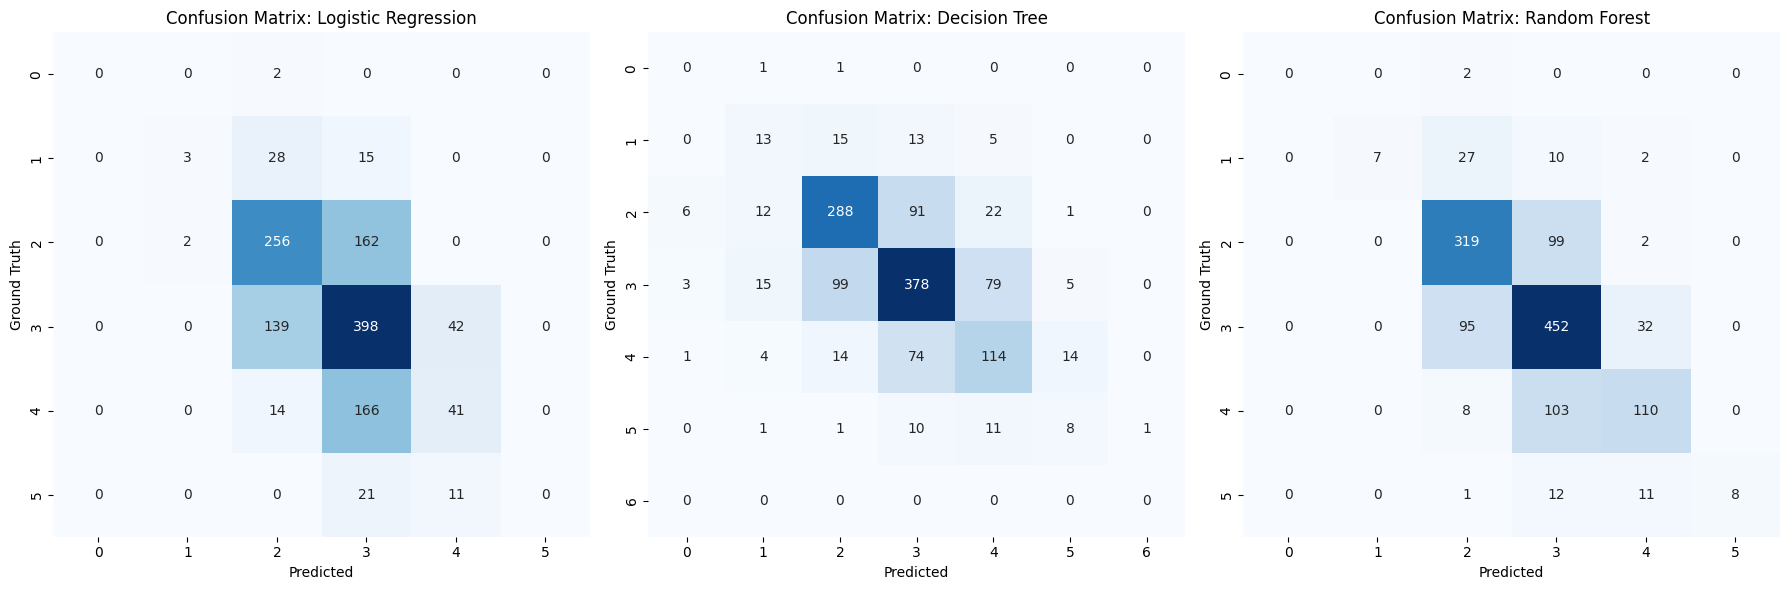

In [24]:
# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, (model_name, cm) in enumerate(conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", ax=axes[i], cbar=False)
    axes[i].set_title(f"Confusion Matrix: {model_name}")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Ground Truth")

plt.tight_layout()
# plt.show()
plt.savefig(os.path.join(output_path, "wine_metrix.png"))


In [25]:
# Display classification reports
for model_name, report in class_reports.items():
    print(f"\nClassification Report for {model_name}:\n{report}")


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.60      0.07      0.12        46
           2       0.58      0.61      0.60       420
           3       0.52      0.69      0.59       579
           4       0.44      0.19      0.26       221
           5       0.00      0.00      0.00        32

    accuracy                           0.54      1300
   macro avg       0.36      0.26      0.26      1300
weighted avg       0.52      0.54      0.51      1300


Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.28      0.28      0.28        46
           2       0.69      0.69      0.69       420
           3       0.67      0.65      0.66       579
           4       0.49      0.52      0.50       221
           5       0.29      0.25      0.2